# Build Recommendation Model
## - Model Training
This notebook builds the collaborative filtering recommendation model.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Load the data we saved in the previous notebook
# This is much faster than querying BigQuery again!

print("Loading data from local files...")

# Try pickle first (faster), fallback to CSV
try:
    ratings_df = pd.read_pickle('../../data/ratings_sample.pkl')
    movies_df = pd.read_pickle('../../data/movies_sample.pkl')
    print("✅ Loaded from pickle files (fast!)")
except:
    ratings_df = pd.read_csv('../../data/ratings_sample.csv')
    movies_df = pd.read_csv('../../data/movies_sample.csv')
    print("✅ Loaded from CSV files")

print(f"\n📊 Data loaded:")
print(f"  • Ratings: {len(ratings_df):,} rows")
print(f"  • Movies: {len(movies_df):,} rows")
print(f"  • Users: {ratings_df['userId'].nunique():,}")
print(f"  • Movies rated: {ratings_df['movieId'].nunique():,}")

Loading data from local files...
✅ Loaded from pickle files (fast!)

📊 Data loaded:
  • Ratings: 100,000 rows
  • Movies: 10,329 rows
  • Users: 668
  • Movies rated: 10,283


In [3]:
# Prepare the data for collaborative filtering
print("=" * 80)
print("PREPARING DATA FOR MODELING")
print("=" * 80)

# Check for any data issues
print("\n🔍 Data quality check:")
print(f"  • Missing values in ratings: {ratings_df.isnull().sum().sum()}")
print(f"  • Duplicate ratings: {ratings_df.duplicated(['userId', 'movieId']).sum()}")

# Remove duplicates if any (keep the last rating)
if ratings_df.duplicated(['userId', 'movieId']).sum() > 0:
    print("  ⚠️  Removing duplicate ratings...")
    ratings_df = ratings_df.drop_duplicates(['userId', 'movieId'], keep='last')
    print(f"  ✅ After removing duplicates: {len(ratings_df):,} ratings")

# Basic statistics
print(f"\n📈 Rating statistics:")
print(f"  • Mean: {ratings_df['rating'].mean():.2f}")
print(f"  • Median: {ratings_df['rating'].median():.2f}")
print(f"  • Std: {ratings_df['rating'].std():.2f}")
print(f"  • Min: {ratings_df['rating'].min():.1f}")
print(f"  • Max: {ratings_df['rating'].max():.1f}")

PREPARING DATA FOR MODELING

🔍 Data quality check:
  • Missing values in ratings: 0
  • Duplicate ratings: 0

📈 Rating statistics:
  • Mean: 3.44
  • Median: 3.50
  • Std: 1.01
  • Min: 0.5
  • Max: 5.0


In [4]:
# Create the user-item rating matrix
# This is the core data structure for collaborative filtering

print("\n" + "=" * 80)
print("CREATING USER-ITEM MATRIX")
print("=" * 80)

# Create pivot table: rows = users, columns = movies, values = ratings
user_item_matrix = ratings_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

print(f"\n📐 User-Item Matrix shape: {user_item_matrix.shape}")
print(f"  • Users (rows): {user_item_matrix.shape[0]:,}")
print(f"  • Movies (columns): {user_item_matrix.shape[1]:,}")
print(f"  • Total cells: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")

# Calculate sparsity
num_ratings = (user_item_matrix > 0).sum().sum()
total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
sparsity = (1 - num_ratings / total_cells) * 100

print(f"\n🔍 Matrix sparsity:")
print(f"  • Non-zero ratings: {num_ratings:,}")
print(f"  • Total possible ratings: {total_cells:,}")
print(f"  • Sparsity: {sparsity:.2f}%")
print(f"  • Density: {100-sparsity:.2f}%")

# Show a small sample
print(f"\n📋 Sample of user-item matrix (first 5 users, first 5 movies):")
print(user_item_matrix.iloc[:5, :5])


CREATING USER-ITEM MATRIX

📐 User-Item Matrix shape: (668, 10283)
  • Users (rows): 668
  • Movies (columns): 10,283
  • Total cells: 6,869,044

🔍 Matrix sparsity:
  • Non-zero ratings: 100,000
  • Total possible ratings: 6,869,044
  • Sparsity: 98.54%
  • Density: 1.46%

📋 Sample of user-item matrix (first 5 users, first 5 movies):
movieId    1    2    3    4    5
userId                          
1        0.0  0.0  0.0  0.0  0.0
2        5.0  0.0  2.0  0.0  3.0
3        0.0  0.0  0.0  0.0  3.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0


In [5]:
# Calculate item-item similarity matrix
# Items (movies) that are rated similarly by users are considered similar

print("\n" + "=" * 80)
print("CALCULATING ITEM-ITEM SIMILARITY")
print("=" * 80)

print("\n⏳ Computing similarity matrix... (this may take a minute)")

# Calculate cosine similarity between all pairs of movies
# Transpose the matrix so movies are rows (similarity between rows)
item_similarity = cosine_similarity(user_item_matrix.T)

# Convert to DataFrame for easier handling
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

print(f"✅ Item similarity matrix created!")
print(f"  • Shape: {item_similarity_df.shape}")
print(f"  • Size in memory: {item_similarity_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show sample similarities
print(f"\n📋 Sample similarities (first 5 movies):")
print(item_similarity_df.iloc[:5, :5].round(3))

# Find some interesting similar movies
sample_movie_id = user_item_matrix.columns[0]
similar_to_sample = item_similarity_df[sample_movie_id].sort_values(ascending=False)[1:6]

print(f"\n🎬 Example: Movies most similar to movie ID {sample_movie_id}:")
for movie_id, similarity in similar_to_sample.items():
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values
    if len(movie_title) > 0:
        print(f"  • {movie_title[0]}: {similarity:.3f}")


CALCULATING ITEM-ITEM SIMILARITY

⏳ Computing similarity matrix... (this may take a minute)
✅ Item similarity matrix created!
  • Shape: (10283, 10283)
  • Size in memory: 807.07 MB

📋 Sample similarities (first 5 movies):
movieId      1      2      3      4      5
movieId                                   
1        1.000  0.339  0.318  0.117  0.329
2        0.339  1.000  0.217  0.126  0.198
3        0.318  0.217  1.000  0.185  0.523
4        0.117  0.126  0.185  1.000  0.127
5        0.329  0.198  0.523  0.127  1.000

🎬 Example: Movies most similar to movie ID 1:
  • Star Wars: Episode VI - Return of the Jedi (1983): 0.591
  • Star Wars: Episode IV - A New Hope (1977): 0.587
  • Independence Day (a.k.a. ID4) (1996): 0.573
  • Back to the Future (1985): 0.555
  • Jurassic Park (1993): 0.550


In [6]:
# Create the main recommendation function

def get_recommendations(user_ratings, item_similarity_df, movies_df, n_recommendations=10):
    """
    Generate movie recommendations based on user's ratings using item-based collaborative filtering
    
    Args:
        user_ratings (dict): Dictionary of {movieId: rating} that the user has rated
        item_similarity_df (DataFrame): Item-item similarity matrix
        movies_df (DataFrame): Movies metadata
        n_recommendations (int): Number of recommendations to return
    
    Returns:
        DataFrame: Recommended movies with scores
    """
    
    # Initialize scores for all movies
    scores = {}
    
    # For each movie the user has rated
    for movie_id, rating in user_ratings.items():
        # Check if movie exists in our similarity matrix
        if movie_id not in item_similarity_df.columns:
            continue
        
        # Get similarity scores for this movie with all other movies
        similar_movies = item_similarity_df[movie_id]
        
        # Calculate weighted scores for all similar movies
        for other_movie_id, similarity in similar_movies.items():
            # Skip if user already rated this movie
            if other_movie_id in user_ratings:
                continue
            
            # Skip if similarity is negative or zero
            if similarity <= 0:
                continue
            
            # Add weighted score (similarity * user's rating)
            if other_movie_id not in scores:
                scores[other_movie_id] = 0
            scores[other_movie_id] += similarity * rating
    
    # If no scores generated, return empty DataFrame
    if not scores:
        print("⚠️  No recommendations could be generated")
        return pd.DataFrame()
    
    # Sort by score and get top N
    top_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    recommended_ids = [movie_id for movie_id, score in top_movies]
    
    # Get movie details
    recommendations = movies_df[movies_df['movieId'].isin(recommended_ids)].copy()
    
    # Add scores
    score_dict = dict(top_movies)
    recommendations['score'] = recommendations['movieId'].map(score_dict)
    
    # Sort by score
    recommendations = recommendations.sort_values('score', ascending=False)
    
    return recommendations[['movieId', 'title', 'genres', 'score']]


print("✅ Recommendation function created!")
print("\n📝 Function: get_recommendations(user_ratings, item_similarity_df, movies_df, n_recommendations)")

✅ Recommendation function created!

📝 Function: get_recommendations(user_ratings, item_similarity_df, movies_df, n_recommendations)


In [7]:
# Test the recommendation function with a sample user

print("=" * 80)
print("TESTING RECOMMENDATION FUNCTION")
print("=" * 80)

# Create a test user with some ratings
# Let's pick some popular movies and rate them highly
test_user_ratings = {
    1: 5.0,      # Movie ID 1
    2: 4.0,      # Movie ID 2
    3: 4.5,      # Movie ID 3
    50: 3.5,     # Movie ID 50
    100: 4.0     # Movie ID 100
}

print("\n Test User's Ratings:")
for movie_id, rating in test_user_ratings.items():
    movie_info = movies_df[movies_df['movieId'] == movie_id]
    if not movie_info.empty:
        title = movie_info['title'].values[0]
        genres = movie_info['genres'].values[0]
        print(f"  • {title}")
        print(f"    Rating: {rating} ⭐ | Genres: {genres}")

print("\n Generating recommendations...")
recommendations = get_recommendations(
    test_user_ratings, 
    item_similarity_df, 
    movies_df, 
    n_recommendations=10
)

print(f"\n Top 10 Recommendations:")
print("=" * 80)
for idx, row in recommendations.iterrows():
    print(f"{recommendations.index.get_loc(idx) + 1}. {row['title']}")
    print(f"   Score: {row['score']:.3f} | Genres: {row['genres']}")
    print()

TESTING RECOMMENDATION FUNCTION

 Test User's Ratings:
  • Toy Story (1995)
    Rating: 5.0 ⭐ | Genres: Adventure|Animation|Children|Comedy|Fantasy
  • Jumanji (1995)
    Rating: 4.0 ⭐ | Genres: Adventure|Children|Fantasy
  • Grumpier Old Men (1995)
    Rating: 4.5 ⭐ | Genres: Comedy|Romance
  • Usual Suspects, The (1995)
    Rating: 3.5 ⭐ | Genres: Crime|Mystery|Thriller
  • City Hall (1996)
    Rating: 4.0 ⭐ | Genres: Drama|Thriller

 Generating recommendations...

 Top 10 Recommendations:
1. Mission: Impossible (1996)
   Score: 8.254 | Genres: Action|Adventure|Mystery|Thriller

2. Independence Day (a.k.a. ID4) (1996)
   Score: 8.251 | Genres: Action|Adventure|Sci-Fi|Thriller

3. Jurassic Park (1993)
   Score: 7.798 | Genres: Action|Adventure|Sci-Fi|Thriller

4. Star Wars: Episode IV - A New Hope (1977)
   Score: 7.788 | Genres: Action|Adventure|Sci-Fi

5. Star Wars: Episode VI - Return of the Jedi (1983)
   Score: 7.762 | Genres: Action|Adventure|Sci-Fi

6. Twister (1996)
   Score: 

In [8]:
# Test with different types of user preferences

print("=" * 80)
print("TESTING WITH DIFFERENT USER PROFILES")
print("=" * 80)

# Profile 1: Action movie lover
print("\n🎬 PROFILE 1: Action Movie Lover")
print("-" * 80)

# Find some action movies to rate
action_movies = movies_df[movies_df['genres'].str.contains('Action', na=False)]['movieId'].head(5).tolist()
action_profile = {movie_id: 5.0 for movie_id in action_movies}

print("Rated movies:")
for movie_id in action_movies[:3]:
    title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  • {title}: 5.0 ⭐")

recs_action = get_recommendations(action_profile, item_similarity_df, movies_df, n_recommendations=5)
print("\nRecommended movies:")
for idx, row in recs_action.iterrows():
    print(f"  • {row['title']} (Score: {row['score']:.2f})")

# Profile 2: Comedy movie lover
print("\n\n😂 PROFILE 2: Comedy Movie Lover")
print("-" * 80)

comedy_movies = movies_df[movies_df['genres'].str.contains('Comedy', na=False)]['movieId'].head(5).tolist()
comedy_profile = {movie_id: 5.0 for movie_id in comedy_movies}

print("Rated movies:")
for movie_id in comedy_movies[:3]:
    title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  • {title}: 5.0 ⭐")

recs_comedy = get_recommendations(comedy_profile, item_similarity_df, movies_df, n_recommendations=5)
print("\nRecommended movies:")
for idx, row in recs_comedy.iterrows():
    print(f"  • {row['title']} (Score: {row['score']:.2f})")

# Profile 3: Mixed preferences
print("\n\n🎭 PROFILE 3: Mixed Preferences")
print("-" * 80)

mixed_profile = {
    action_movies[0]: 5.0,
    comedy_movies[0]: 4.5,
    action_movies[1]: 4.0,
    comedy_movies[1]: 3.5
}

print("Rated movies:")
for movie_id, rating in mixed_profile.items():
    title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  • {title}: {rating} ⭐")

recs_mixed = get_recommendations(mixed_profile, item_similarity_df, movies_df, n_recommendations=5)
print("\nRecommended movies:")
for idx, row in recs_mixed.iterrows():
    print(f"  • {row['title']} (Score: {row['score']:.2f})")

TESTING WITH DIFFERENT USER PROFILES

🎬 PROFILE 1: Action Movie Lover
--------------------------------------------------------------------------------
Rated movies:
  • Sudden Death (1995): 5.0 ⭐
  • Fair Game (1995): 5.0 ⭐
  • Under Siege 2: Dark Territory (1995): 5.0 ⭐

Recommended movies:
  • Striking Distance (1993) (Score: 7.47)
  • Hard Target (1993) (Score: 7.46)
  • NeverEnding Story III, The (1994) (Score: 7.07)
  • Specialist, The (1994) (Score: 6.70)
  • Terminal Velocity (1994) (Score: 6.53)


😂 PROFILE 2: Comedy Movie Lover
--------------------------------------------------------------------------------
Rated movies:
  • Incredibles, The (2004): 5.0 ⭐
  • Bolt (2008): 5.0 ⭐
  • TMNT (Teenage Mutant Ninja Turtles) (2007): 5.0 ⭐

Recommended movies:
  • Despicable Me 2 (2013) (Score: 8.73)
  • Up (2009) (Score: 8.18)
  • WALL·E (2008) (Score: 8.12)
  • Kung Fu Panda (2008) (Score: 8.00)
  • Faster (2010) (Score: 7.95)


🎭 PROFILE 3: Mixed Preferences
------------------------

In [12]:
# Evaluate recommendation model using simple metrics

print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

def evaluate_model_simple(ratings_df, user_item_matrix, item_similarity_df, movies_df, test_size=0.2, n_recommendations=20):
    """
    Simple evaluation: For each user in test set, check if their held-out movies
    appear in the top-N recommendations
    """
    
    print(f"\n⏳ Running evaluation with test size = {test_size:.0%}...")
    
    # Get unique users
    users = ratings_df['userId'].unique()
    
    # Sample users for evaluation (to speed up)
    sample_size = min(100, len(users))
    sampled_users = np.random.choice(users, sample_size, replace=False)
    
    hit_count = 0
    total_count = 0
    precision_scores = []
    
    for user_id in sampled_users:
        # Get this user's ratings
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        
        # Need at least 5 ratings to split
        if len(user_ratings) < 5:
            continue
        
        # Split into train and test
        train_ratings, test_ratings = train_test_split(user_ratings, test_size=test_size, random_state=42)
        
        # Create user profile from train ratings
        user_profile = dict(zip(train_ratings['movieId'], train_ratings['rating']))
        
        # Get recommendations
        try:
            recs = get_recommendations(user_profile, item_similarity_df, movies_df, n_recommendations)
            
            if recs.empty:
                continue
            
            # Check how many test movies appear in recommendations
            recommended_ids = set(recs['movieId'].values)
            test_movie_ids = set(test_ratings['movieId'].values)
            
            hits = len(recommended_ids & test_movie_ids)
            hit_count += hits
            total_count += len(test_movie_ids)
            
            # Calculate precision for this user
            if len(recommended_ids) > 0:
                precision = hits / len(recommended_ids)
                precision_scores.append(precision)
        
        except Exception as e:
            continue
    
    # Calculate metrics
    hit_rate = hit_count / total_count if total_count > 0 else 0
    avg_precision = np.mean(precision_scores) if precision_scores else 0
    
    print(f"\n✅ Evaluation complete!")
    print(f"\n📊 Results (based on {len(sampled_users)} sampled users):")
    print(f"  • Hit Rate (Top-{n_recommendations}): {hit_rate:.2%}")
    print(f"  • Average Precision: {avg_precision:.2%}")
    print(f"  • Total test items: {total_count}")
    print(f"  • Total hits: {hit_count}")
    
    return hit_rate, avg_precision

# Run evaluation
hit_rate, precision = evaluate_model_simple(
    ratings_df, 
    user_item_matrix, 
    item_similarity_df, 
    movies_df,
    test_size=0.2,
    n_recommendations=20
)


MODEL EVALUATION

⏳ Running evaluation with test size = 20%...

✅ Evaluation complete!

📊 Results (based on 100 sampled users):
  • Hit Rate (Top-20): 19.71%
  • Average Precision: 32.45%
  • Total test items: 3293
  • Total hits: 649


In [13]:
# Analyze the diversity of recommendations

print("\n" + "=" * 80)
print("RECOMMENDATION DIVERSITY ANALYSIS")
print("=" * 80)

def analyze_diversity(recommendations_list):
    """
    Analyze diversity of recommendations across different users
    """
    
    all_recommended_movies = []
    for recs in recommendations_list:
        all_recommended_movies.extend(recs['movieId'].tolist())
    
    unique_movies = len(set(all_recommended_movies))
    total_recommendations = len(all_recommended_movies)
    diversity = unique_movies / total_recommendations if total_recommendations > 0 else 0
    
    return unique_movies, total_recommendations, diversity

# Generate recommendations for multiple random users
print("\n⏳ Generating recommendations for 50 random users...")

recommendations_list = []
sampled_users = ratings_df['userId'].sample(50, random_state=42)

for user_id in sampled_users:
    # Get user's actual ratings
    user_ratings_data = ratings_df[ratings_df['userId'] == user_id]
    
    # Take only first 5 ratings as input
    user_profile = dict(zip(
        user_ratings_data['movieId'].head(5),
        user_ratings_data['rating'].head(5)
    ))
    
    # Get recommendations
    try:
        recs = get_recommendations(user_profile, item_similarity_df, movies_df, n_recommendations=10)
        if not recs.empty:
            recommendations_list.append(recs)
    except:
        continue

# Analyze diversity
unique, total, diversity = analyze_diversity(recommendations_list)

print(f"\n📊 Diversity Metrics:")
print(f"  • Total recommendations generated: {total}")
print(f"  • Unique movies recommended: {unique}")
print(f"  • Diversity score: {diversity:.2%}")
print(f"\n💡 Higher diversity means the system recommends a wider variety of movies")

# Find most frequently recommended movies
all_recs = pd.concat(recommendations_list)
top_recommended = all_recs['movieId'].value_counts().head(10)

print(f"\n🔥 Top 10 Most Frequently Recommended Movies:")
for movie_id, count in top_recommended.items():
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  • {movie_title}: recommended {count} times")


RECOMMENDATION DIVERSITY ANALYSIS

⏳ Generating recommendations for 50 random users...

📊 Diversity Metrics:
  • Total recommendations generated: 500
  • Unique movies recommended: 262
  • Diversity score: 52.40%

💡 Higher diversity means the system recommends a wider variety of movies

🔥 Top 10 Most Frequently Recommended Movies:
  • Speed (1994): recommended 14 times
  • True Lies (1994): recommended 12 times
  • Batman (1989): recommended 11 times
  • Batman Forever (1995): recommended 11 times
  • Ace Ventura: Pet Detective (1994): recommended 9 times
  • Mask, The (1994): recommended 9 times
  • Mrs. Doubtfire (1993): recommended 9 times
  • Dumb & Dumber (Dumb and Dumber) (1994): recommended 8 times
  • Home Alone (1990): recommended 8 times
  • Jurassic Park (1993): recommended 6 times


CREATING VISUALIZATIONS
  → Plot 1: Similarity distribution
  → Plot 2: Recommendation scores
  → Plot 3: Similar movies distribution
  → Plot 4: Model metrics

✅ All plots created successfully!
📁 Plot saved to: reports/figures/model_performance.png

📊 Displaying figure...


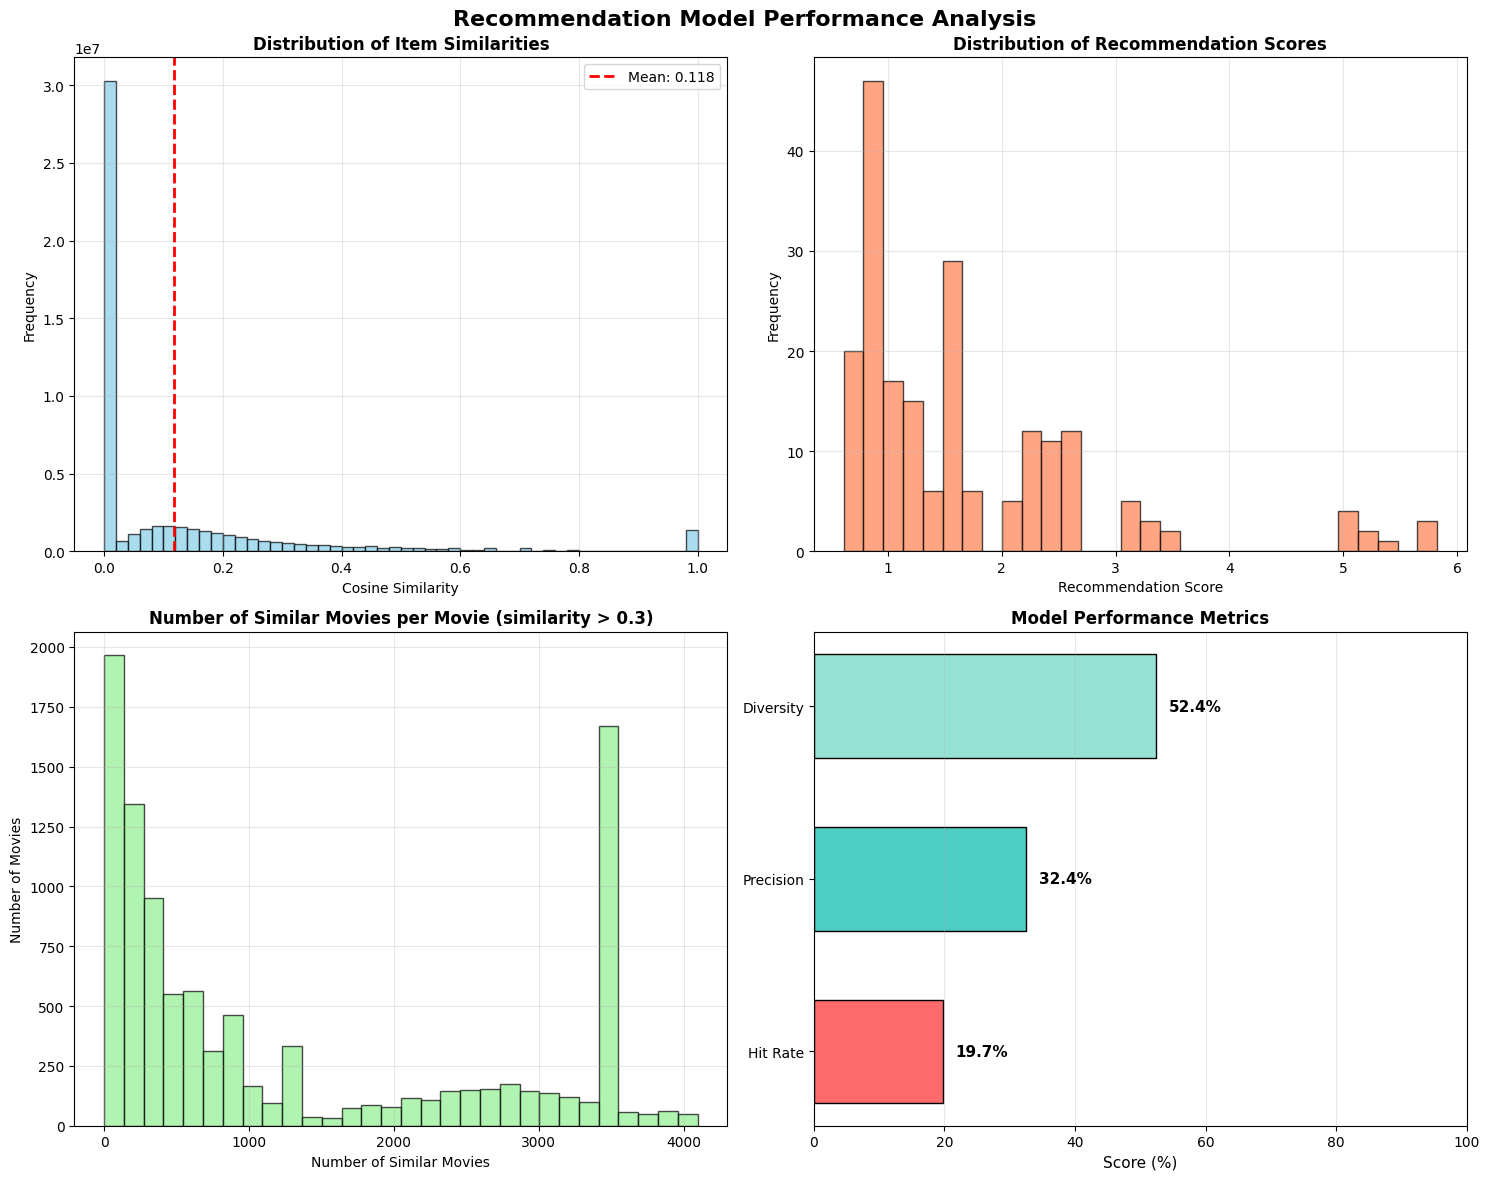

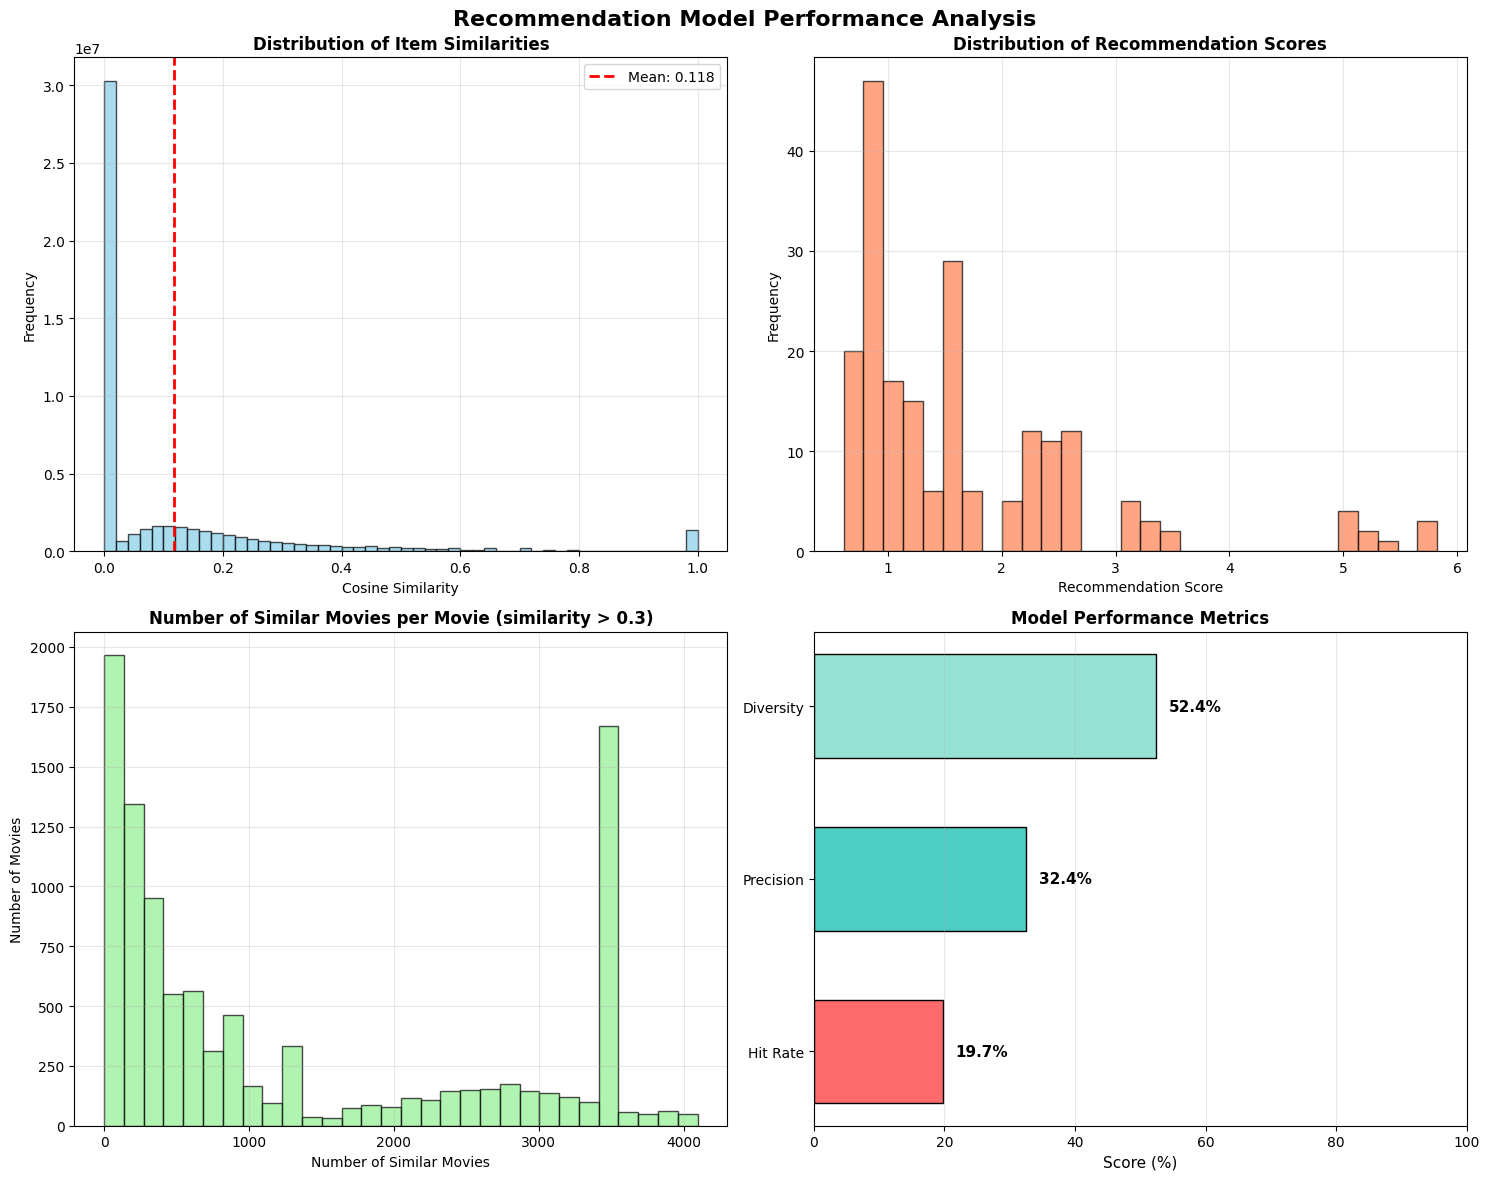


📊 Displaying saved image:


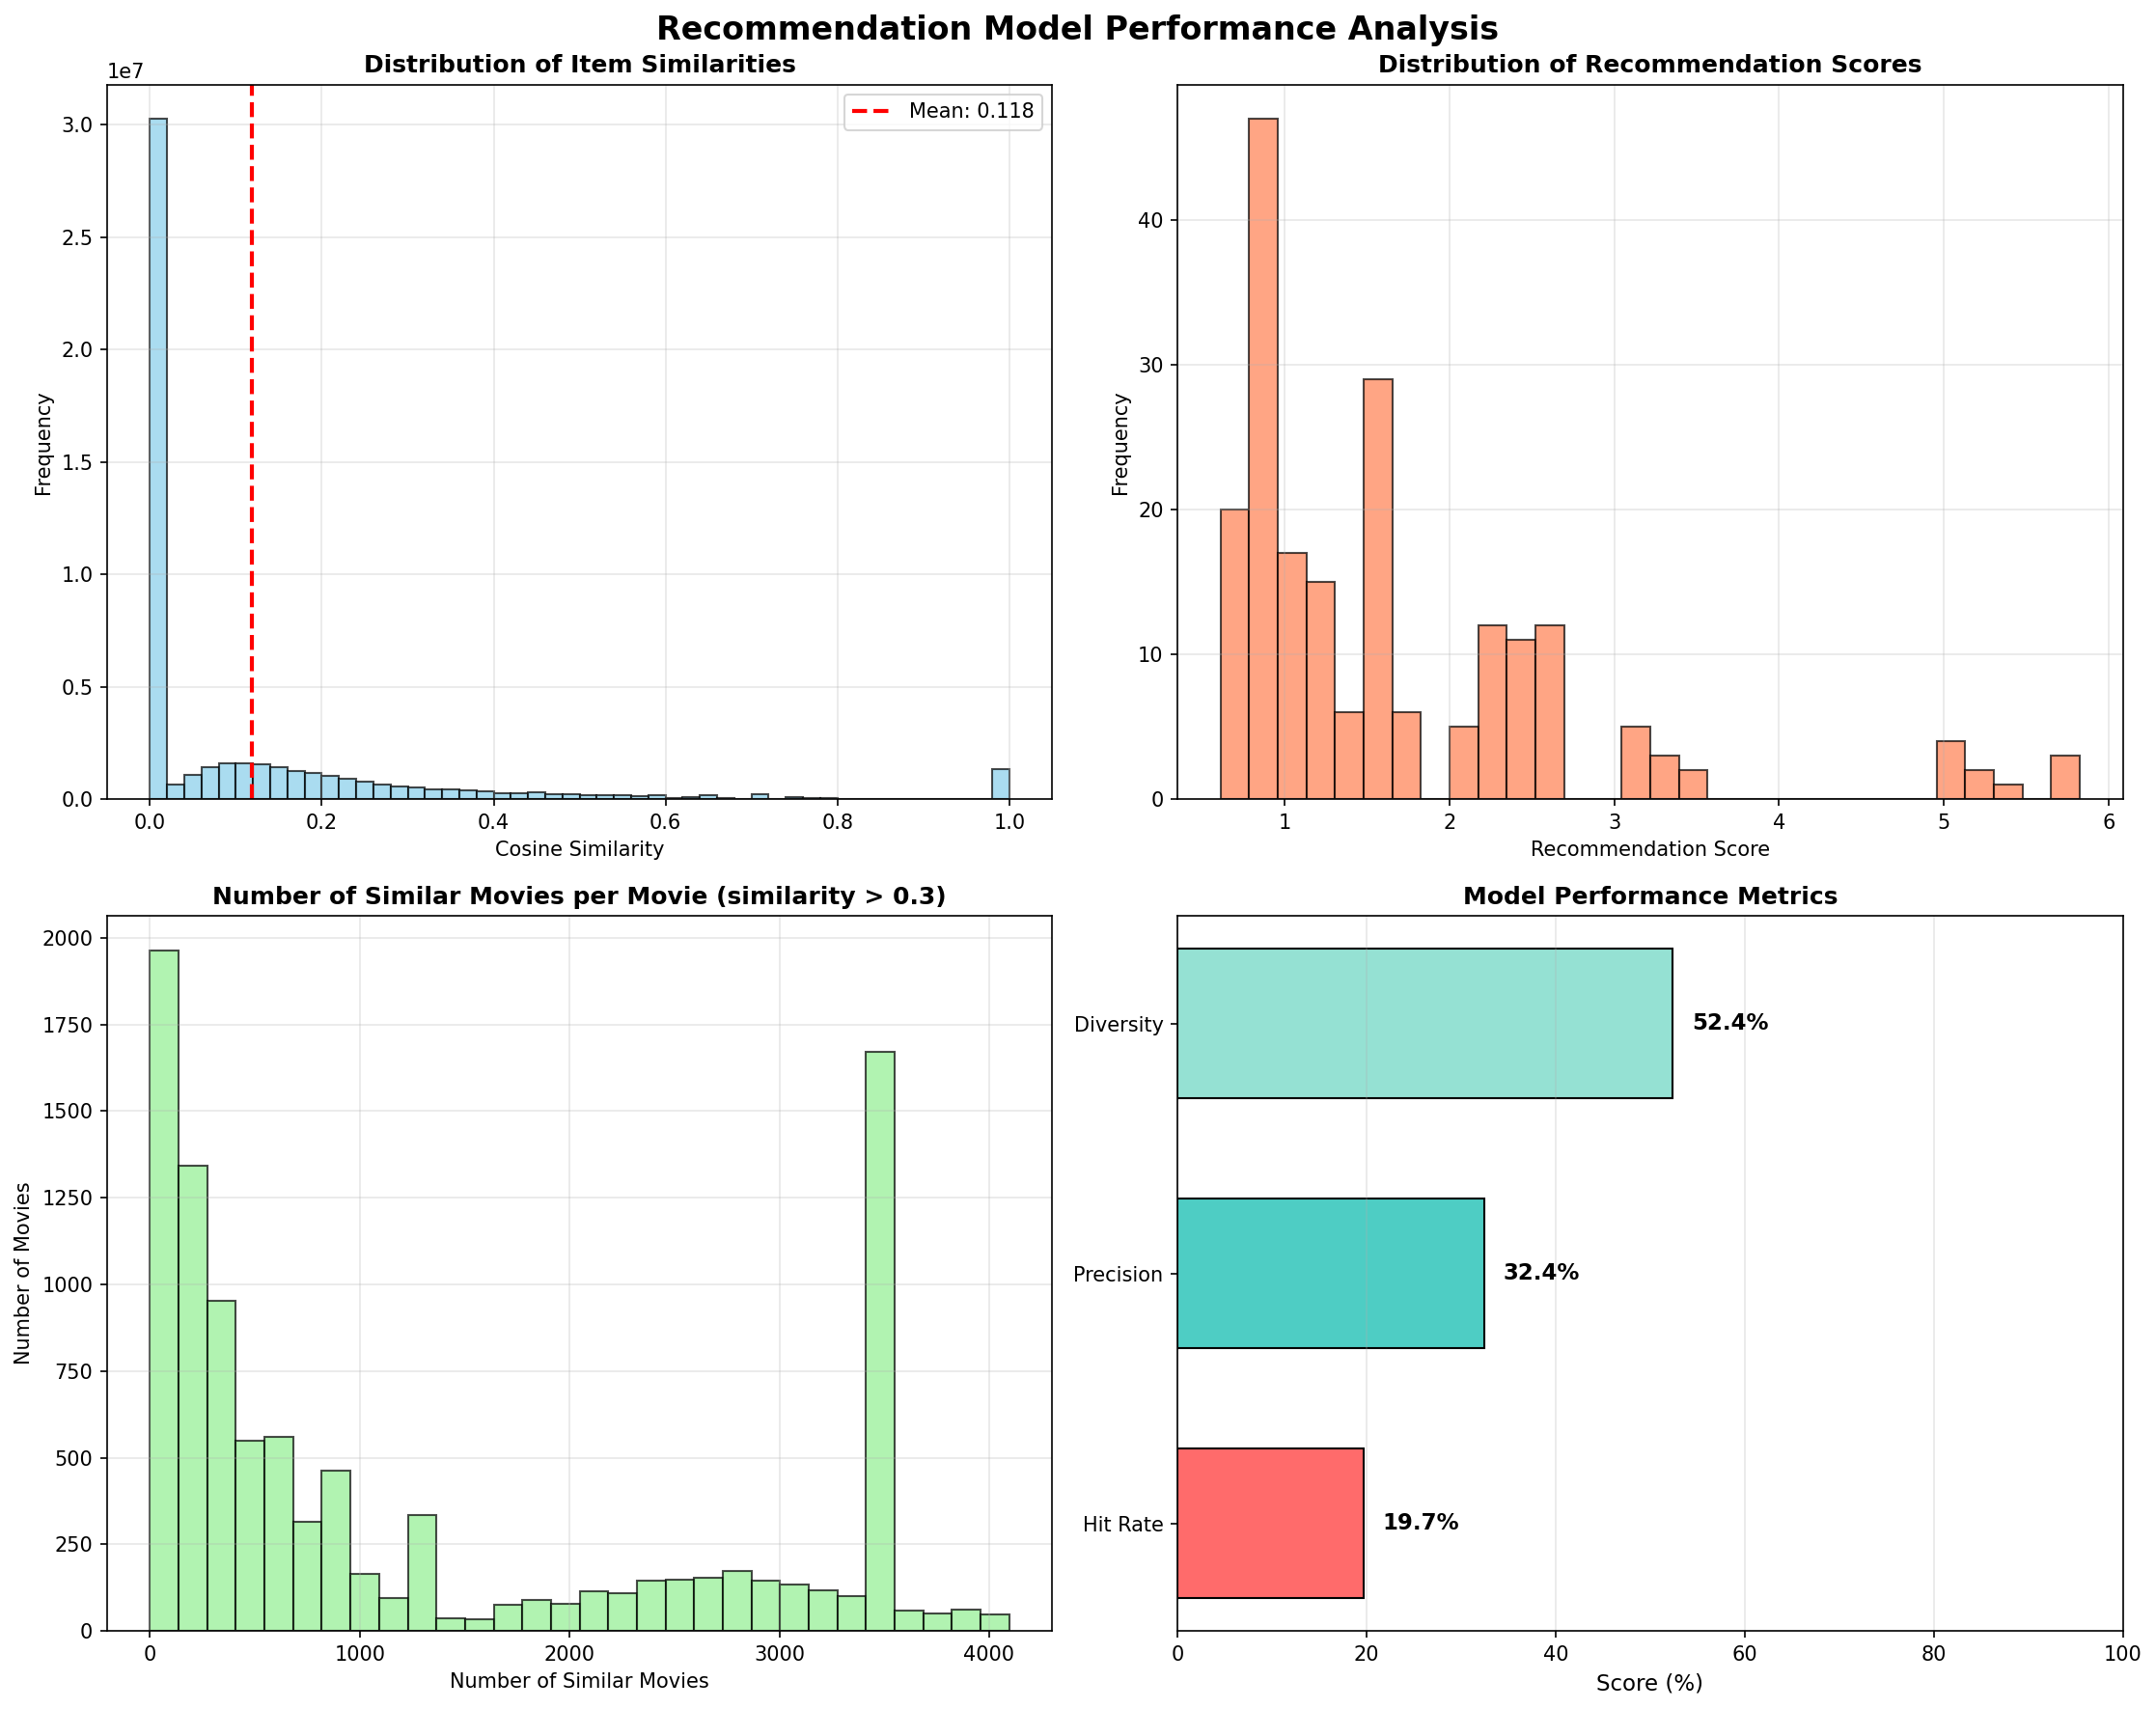


✅ Visualizations complete!
💡 If you don't see plots above, check: reports/figures/model_performance.png


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import os

print("=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Recommendation Model Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Similarity distribution
print("  → Plot 1: Similarity distribution")
similarities = item_similarity_df.values[np.triu_indices_from(item_similarity_df.values, k=1)]
axes[0, 0].hist(similarities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Item Similarities', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(similarities.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {similarities.mean():.3f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Recommendation scores distribution
print("  → Plot 2: Recommendation scores")
all_scores = []
for recs in recommendations_list[:20]:
    if not recs.empty:
        all_scores.extend(recs['score'].tolist())

axes[0, 1].hist(all_scores, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Recommendation Scores', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Recommendation Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Number of similar movies per movie
print("  → Plot 3: Similar movies distribution")
num_similar = (item_similarity_df > 0.3).sum(axis=1) - 1
axes[1, 0].hist(num_similar, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Number of Similar Movies per Movie (similarity > 0.3)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Similar Movies')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Model metrics summary
print("  → Plot 4: Model metrics")
metrics_labels = ['Hit Rate', 'Precision', 'Diversity']
metrics_values = [hit_rate * 100, precision * 100, diversity * 100]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

axes[1, 1].barh(metrics_labels, metrics_values, color=colors, edgecolor='black', height=0.6)
axes[1, 1].set_xlabel('Score (%)', fontsize=11)
axes[1, 1].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim(0, 100)

for i, (label, value) in enumerate(zip(metrics_labels, metrics_values)):
    axes[1, 1].text(value + 2, i, f'{value:.1f}%', va='center', fontweight='bold', fontsize=11)

axes[1, 1].grid(axis='x', alpha=0.3)

# Adjust layout
plt.tight_layout()

print("\n✅ All plots created successfully!")

# Save the figure first
os.makedirs('../../reports/figures', exist_ok=True)
fig.savefig('../../reports/figures/model_performance.png', dpi=150, bbox_inches='tight')
print("📁 Plot saved to: reports/figures/model_performance.png")

# Now try MULTIPLE ways to display
print("\n📊 Displaying figure...")

# Method 1: Standard plt.show()
plt.show()

# Method 2: Explicitly display the figure object
from IPython.display import display
display(fig)

# Method 3: Display the saved image
print("\n📊 Displaying saved image:")
display(Image('../../reports/figures/model_performance.png'))

print("\n✅ Visualizations complete!")
print("💡 If you don't see plots above, check: reports/figures/model_performance.png")

In [20]:
# Save the model components for use in the next notebook

import pickle
import os

print("=" * 80)
print("SAVING MODEL COMPONENTS")
print("=" * 80)

# Create directory for saved models
os.makedirs('../../models/saved_models', exist_ok=True)

# Save model components
model_components = {
    'user_item_matrix': user_item_matrix,
    'item_similarity_df': item_similarity_df,
    'movies_df': movies_df,
    'model_type': 'item_based_collaborative_filtering',
    'metrics': {
        'hit_rate': hit_rate,
        'precision': precision,
        'diversity': diversity
    }
}

# Save as pickle
with open('../../models/saved_models/recommender_components.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("\n✅ Model components saved!")
print(f"  📁 Location: models/saved_models/recommender_components.pkl")
print(f"  📦 Size: {os.path.getsize('../../models/saved_models/recommender_components.pkl') / 1024**2:.2f} MB")

print("\n📦 Saved components:")
print(f"  • User-Item Matrix: {user_item_matrix.shape}")
print(f"  • Item Similarity Matrix: {item_similarity_df.shape}")
print(f"  • Movies DataFrame: {movies_df.shape}")
print(f"  • Model Metrics: Hit Rate={hit_rate:.2%}, Precision={precision:.2%}, Diversity={diversity:.2%}")

SAVING MODEL COMPONENTS

✅ Model components saved!
  📁 Location: models/saved_models/recommender_components.pkl
  📦 Size: 859.68 MB

📦 Saved components:
  • User-Item Matrix: (668, 10283)
  • Item Similarity Matrix: (10283, 10283)
  • Movies DataFrame: (10329, 3)
  • Model Metrics: Hit Rate=19.71%, Precision=32.45%, Diversity=52.40%


In [21]:
# Final summary

print("\n" + "=" * 80)
print("✅ RECOMMENDATION MODEL BUILDING COMPLETE!")
print("=" * 80)

print(f"\n🎯 MODEL SUMMARY:")
print(f"  • Algorithm: Item-Based Collaborative Filtering")
print(f"  • Similarity Metric: Cosine Similarity")
print(f"  • Training Data: {len(ratings_df):,} ratings")
print(f"  • Users: {user_item_matrix.shape[0]:,}")
print(f"  • Movies: {user_item_matrix.shape[1]:,}")
print(f"  • Matrix Sparsity: {sparsity:.2f}%")

print(f"\n📊 PERFORMANCE:")
print(f"  • Hit Rate (Top-20): {hit_rate:.2%}")
print(f"  • Average Precision: {precision:.2%}")
print(f"  • Diversity Score: {diversity:.2%}")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"  • Model components saved to: models/saved_models/recommender_components.pkl")
print(f"  • Ready for deployment!")




✅ RECOMMENDATION MODEL BUILDING COMPLETE!

🎯 MODEL SUMMARY:
  • Algorithm: Item-Based Collaborative Filtering
  • Similarity Metric: Cosine Similarity
  • Training Data: 100,000 ratings
  • Users: 668
  • Movies: 10,283
  • Matrix Sparsity: 98.54%

📊 PERFORMANCE:
  • Hit Rate (Top-20): 19.71%
  • Average Precision: 32.45%
  • Diversity Score: 52.40%

💾 SAVED ARTIFACTS:
  • Model components saved to: models/saved_models/recommender_components.pkl
  • Ready for deployment!
